In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as opt

Cross-referencing with equations in the SI of the paper and rewriting in more pythonic way

Both DIC method and CO2 equilibrium method implemented now

In [62]:
T = 298.15 # K
input_parameters = {
    'Method': 'CO2 eql', # 'DIC' or 'CO2 eql'
    'Temperature': T
}
physical_constants = {
    'Henry constant': 1000*np.exp(93.4517*100/T - 60.2409 + 23.3585*np.log(T/100)), # [mol/(m^3 Pa)]
    'R': 8.3145, # [J/(mol K)]
    'F': 96485, # [C/mol]
}
physical_constants

{'Henry constant': 34.06103747827045, 'R': 8.3145, 'F': 96485}

In [63]:
diffusion_coefficients = {
    'CO2': 1.91e-09,
    'OH': 5.293e-09,
    'CO3': 9.23e-10,
    'HCO3': 1.18e-09,
    'H': 9.311e-09,
    'K': 1.96e-09,
    'CO': 2.03e-09,
    'H2': 4.5e-09
} # [m^2/s]
salting_out_exponents = {
    'h_OH': 6.67e-05,
    'h_CO3': 0.0001251,
    'h_HCO3': 7.95e-05,
    'h_K': 7.5e-05,
    'h_CO2': 0.0
} # [m^3/mol]

In [64]:
input_parameters.update({
    'CO2 partial pressure': 1, # atm
    'Flow rate': 5, # mL/min
    'Flow channel active length': 0.02, # m
    'Flow channel height (plane parallel)': 5e-3, # m
    'Flow channel width (plane perpendicular)': 1.5e-3, # m
})
input_parameters['Flow velocity'] = input_parameters['Flow rate'] / (input_parameters['Flow channel height (plane parallel)'] * input_parameters['Flow channel width (plane perpendicular)']) * 1e-6/60 # m/s
input_parameters.update({
    'Catalyst layer length': 3.81E-06, # m
    'Catalyst layer porosity': 0.5,
    'Catalyst layer average particle radius': 5.0e-08, # m
})
input_parameters['Catalyst layer volumetric surface area'] = 3 * (1 - input_parameters['Catalyst layer porosity']) / input_parameters['Catalyst layer average particle radius'] # m^-1
input_parameters['KHCO3 concentration'] = 500 # mol/m^3
input_parameters['K+'] = input_parameters['KHCO3 concentration']
input_parameters['Method 1 (DIC)'] = 10**-3.408

electrode_reaction_kinetics = {
    'i_0_CO': 0.00471, # [A/m^2]
    'i_0_H2a': 0.00979, # [A/m^2]
    'i_0_H2b': 1.16e-05, # [A/m^2]
    'alpha_CO': 0.44,
    'alpha_H2a': 0.27,
    'alpha_H2b': 0.36,
    'E_0_CO2': -0.11, # [V]
    'E_0_H2a': 0.0, # [V]
    'E_0_H2b': 0.0 # [V]
}
alpha_to_b = lambda alpha: T*physical_constants['R']/(alpha*physical_constants['F'])
electrode_reaction_kinetics['b_CO2'] = alpha_to_b(electrode_reaction_kinetics['alpha_CO'])
electrode_reaction_kinetics['b_H2a'] = alpha_to_b(electrode_reaction_kinetics['alpha_H2a'])
electrode_reaction_kinetics['b_H2b'] = alpha_to_b(electrode_reaction_kinetics['alpha_H2b'])
for substance in ['CO2','OH','CO3','HCO3','H','K','CO','H2']:
    electrode_reaction_kinetics[f'D{substance}'] = diffusion_coefficients[substance]*input_parameters['Catalyst layer porosity']**1.5

input_parameters['Gas diffusion layer mass transfer coefficient'] = electrode_reaction_kinetics['DCO2'] / input_parameters['Catalyst layer average particle radius'] # [m/s]

input_parameters

{'Method': 'CO2 eql',
 'Temperature': 298.15,
 'CO2 partial pressure': 1,
 'Flow rate': 5,
 'Flow channel active length': 0.02,
 'Flow channel height (plane parallel)': 0.005,
 'Flow channel width (plane perpendicular)': 0.0015,
 'Flow velocity': 0.01111111111111111,
 'Catalyst layer length': 3.81e-06,
 'Catalyst layer porosity': 0.5,
 'Catalyst layer average particle radius': 5e-08,
 'Catalyst layer volumetric surface area': 30000000.0,
 'KHCO3 concentration': 500,
 'K+': 500,
 'Method 1 (DIC)': 0.0003908408957924021,
 'Gas diffusion layer mass transfer coefficient': 0.013505739520663057}

In [65]:
electrode_reaction_kinetics

{'i_0_CO': 0.00471,
 'i_0_H2a': 0.00979,
 'i_0_H2b': 1.16e-05,
 'alpha_CO': 0.44,
 'alpha_H2a': 0.27,
 'alpha_H2b': 0.36,
 'E_0_CO2': -0.11,
 'E_0_H2a': 0.0,
 'E_0_H2b': 0.0,
 'b_CO2': 0.058392688807021344,
 'b_H2a': 0.09515845583366442,
 'b_H2b': 0.07136884187524832,
 'DCO2': 6.752869760331528e-10,
 'DOH': 1.871358096410198e-09,
 'DCO3': 3.2632977951759173e-10,
 'DHCO3': 4.171930009000631e-10,
 'DH': 3.291935619813972e-09,
 'DK': 6.929646455628165e-10,
 'DCO': 7.177133829043458e-10,
 'DH2': 1.590990257669732e-09}

In [66]:
T = input_parameters['Temperature']
kco3_to_salinity = lambda x: x/(1.005*x/1000+19.924)
initial_carbonate_equilibria = {
    'Salinity': kco3_to_salinity(input_parameters['KHCO3 concentration']),
    'pK1_0': -126.34048 + 6320.813/T + 19.568224*np.log(T),
    'pK2_0': -90.18333 + 5143.692/T + 14.613358*np.log(T),
}
salinity_to_A1 = lambda x: 13.4191*x**0.5 + 0.0331*x - 5.33e-5*x**2
initial_carbonate_equilibria['A1'] = salinity_to_A1(initial_carbonate_equilibria['Salinity'])
salinity_to_A2 = lambda x: 21.0894*x**0.5 + 0.1248*x - 3.687e-4*x**2
initial_carbonate_equilibria['A2'] = salinity_to_A2(initial_carbonate_equilibria['Salinity'])
salinity_to_B1 = lambda x: -530.123*x**0.5 - 6.103*x
initial_carbonate_equilibria['B1'] = salinity_to_B1(initial_carbonate_equilibria['Salinity'])
salinity_to_B2 = lambda x: -772.483*x**0.5 - 20.051*x
initial_carbonate_equilibria['B2'] = salinity_to_B2(initial_carbonate_equilibria['Salinity'])
initial_carbonate_equilibria['C1'] = -2.0695*initial_carbonate_equilibria['Salinity']**0.5
initial_carbonate_equilibria['C2'] = -3.3336*initial_carbonate_equilibria['Salinity']**0.5
initial_carbonate_equilibria['pK1'] = initial_carbonate_equilibria['pK1_0'] + initial_carbonate_equilibria['A1'] + initial_carbonate_equilibria['B1']/T + initial_carbonate_equilibria['C1']*np.log(T)
initial_carbonate_equilibria['pK2'] = initial_carbonate_equilibria['pK2_0'] + initial_carbonate_equilibria['A2'] + initial_carbonate_equilibria['B2']/T + initial_carbonate_equilibria['C2']*np.log(T)
initial_carbonate_equilibria['K1'] = 10**-initial_carbonate_equilibria['pK1']
initial_carbonate_equilibria['K2'] = 10**-initial_carbonate_equilibria['pK2']
initial_carbonate_equilibria['Kw'] = np.exp(148.96502 - 13847.26/T - 23.6521*np.log(T) + (-5.977 + 118.67/T + 1.0495*np.log(T))*initial_carbonate_equilibria['Salinity']**0.5 - 0.01615*initial_carbonate_equilibria['Salinity'])

initial_carbonate_equilibria

{'Salinity': 24.47800651114973,
 'pK1_0': 6.351479474463076,
 'pK2_0': 10.329718047170417,
 'A1': 67.16962274581519,
 'A2': 107.17428008515591,
 'B1': -2772.186223903275,
 'B2': -4312.687688396103,
 'C1': -10.238903590992985,
 'C2': -16.493070312120906,
 'pK1': 5.886000594241267,
 'pK2': 9.068309507810866,
 'K1': 1.3001677990240674e-06,
 'K2': 8.544575512302501e-10,
 'Kw': 4.8746440592899435e-14}

In [67]:
chemical_reaction_rates = {
    'k1f': 2.23, # [m^3/(mol s)]
    'k1r': 0.000840308, # [1/s]
    'k2f': 6000000.0, # [m^3/(mol s)]
    'k2r': 345200.0, # [1/s]
    'c_ref': 1000.0 # [mol/m^3]
    }

In [68]:
dic_electrolyte_solution = {
    'A': 1,
    'B': initial_carbonate_equilibria['K1'] + input_parameters['KHCO3 concentration']/1000,
    'C': initial_carbonate_equilibria['K1']*initial_carbonate_equilibria['K2'] - initial_carbonate_equilibria['Kw'],
    'D': -initial_carbonate_equilibria['K1']*(initial_carbonate_equilibria['Kw'] + initial_carbonate_equilibria['K2']*input_parameters['KHCO3 concentration']/1000),
    'E': -initial_carbonate_equilibria['Kw']*initial_carbonate_equilibria['K2']*initial_carbonate_equilibria['K1'],
    'initial_pH': 7,
}
x_n = 1e-4
f_xn = lambda x: dic_electrolyte_solution['A']*x**4 + dic_electrolyte_solution['B']*x**3 + dic_electrolyte_solution['C']*x**2 + dic_electrolyte_solution['D']*x + dic_electrolyte_solution['E']
df_xn = lambda x: 4*dic_electrolyte_solution['A']*x**3 + 3*dic_electrolyte_solution['B']*x**2 + 2*dic_electrolyte_solution['C']*x + dic_electrolyte_solution['D']
# find root of f(x) = 0
x_n = opt.newton(f_xn, x_n, fprime=df_xn, tol=1e-35)
dic_electrolyte_solution['final_pH'] = -np.log10(x_n)
dic_electrolyte_solution['CO2'] = input_parameters['KHCO3 concentration']/(1 + initial_carbonate_equilibria['K1']/x_n + initial_carbonate_equilibria['K1']*initial_carbonate_equilibria['K2']/x_n**2)
dic_electrolyte_solution['HCO3'] = dic_electrolyte_solution['CO2']*initial_carbonate_equilibria['K1']/x_n
dic_electrolyte_solution['CO3'] = dic_electrolyte_solution['HCO3']*initial_carbonate_equilibria['K2']/x_n
dic_electrolyte_solution['OH'] = initial_carbonate_equilibria['Kw']/x_n * 1000
dic_electrolyte_solution['K'] = input_parameters['KHCO3 concentration']
dic_electrolyte_solution

{'A': 1,
 'B': 0.500001300167799,
 'C': -4.7635502399156905e-14,
 'D': -5.555324754236402e-16,
 'E': -5.415428266365318e-29,
 'initial_pH': 7,
 'final_pH': 7.477129599560376,
 'CO2': 12.193436804360426,
 'HCO3': 475.6145554799038,
 'CO3': 12.192007715735759,
 'OH': 0.0014624213175124347,
 'K': 500}

In [69]:
co2_init = physical_constants['Henry constant']*input_parameters['Method 1 (DIC)']

A = 1
b = input_parameters['KHCO3 concentration']/1000
c = lambda co2: -(initial_carbonate_equilibria['Kw'] + initial_carbonate_equilibria['K1']*co2/1000)
d = lambda co2: -2*co2/1000*initial_carbonate_equilibria['K1']*initial_carbonate_equilibria['K2']
f_xn = lambda x, a,b,c,d: a*x**3 + b*x**2 + c*x + d
df_xn = lambda x, a,b,c,d: 3*a*x**2 + 2*b*x + c 
xn_to_co2 = lambda xn, co2: physical_constants['Henry constant']*input_parameters['Method 1 (DIC)']*np.exp(
    -input_parameters['K+']*salting_out_exponents['h_K'] -
    salting_out_exponents['h_HCO3']*co2*initial_carbonate_equilibria['K1']/xn -
    co2*salting_out_exponents['h_CO3']*initial_carbonate_equilibria['K1']*initial_carbonate_equilibria['K2']/xn**2 -
    salting_out_exponents['h_OH']*initial_carbonate_equilibria['Kw']/xn*1000
)
# find root of f(x) = 0
co2 = co2_init
for i in range(3):
    x_n = opt.newton(f_xn, x0=1e-5, fprime=df_xn, tol=1e-36, args=(A,b,c(co2),d(co2)))
    co2 = xn_to_co2(x_n, co2)

co2_equilibrium_sol = {
    'final_pH': -np.log10(x_n),
    'CO2': co2,
    'HCO3': co2*initial_carbonate_equilibria['K1']/x_n,
    'OH': initial_carbonate_equilibria['Kw']/x_n * 1000,
    'K': input_parameters['K+'],
}
co2_equilibrium_sol['CO3'] = co2_equilibrium_sol['HCO3']*initial_carbonate_equilibria['K2']/x_n
co2_equilibrium_sol

{'final_pH': 9.599255514698061,
 'CO2': 0.012414142330721354,
 'HCO3': 64.14630439620164,
 'OH': 0.1937306895325272,
 'K': 500,
 'CO3': 217.8299780419416}

In [70]:
input_parameters['Flow velocity']

0.01111111111111111

In [71]:
flow_channel_characteristics = {
    'mu': 0.00000093944, # [m^2/s]
}
flow_channel_characteristics['Reynolds Number'] = input_parameters['Flow velocity']*input_parameters['Flow channel active length']/flow_channel_characteristics['mu']
flow_channel_characteristics['Hydrodynamic Entrance length'] = 0.0099*flow_channel_characteristics['Reynolds Number']*input_parameters['Flow channel width (plane perpendicular)']
flow_channel_characteristics['Parallel plate effective boundary layer'] = 13/35*input_parameters['Flow channel width (plane perpendicular)']
diff_coeff_to_bl_thickness = lambda x: 3*1.607/4*(input_parameters['Flow channel width (plane perpendicular)']*x*input_parameters['Flow channel active length']/input_parameters['Flow velocity'])**(1/3)
diff_coeff_to_K_L = lambda D,L: D*np.sqrt(L**-2+flow_channel_characteristics['Parallel plate effective boundary layer']**-2)/np.sqrt(2)
for substance in ['CO2', 'OH', 'CO3', 'HCO3', 'H', 'K', 'CO', 'H2']:
    flow_channel_characteristics[f'Developing boundary layer thickness {substance} (average)'] = diff_coeff_to_bl_thickness(diffusion_coefficients[substance])
for substance in ['CO2', 'OH', 'CO3', 'HCO3', 'H', 'K', 'CO', 'H2']:
    flow_channel_characteristics[f'K_L_{substance}'] = diff_coeff_to_K_L(diffusion_coefficients[substance], flow_channel_characteristics[f'Developing boundary layer thickness {substance} (average)'])

flow_channel_characteristics

{'mu': 9.3944e-07,
 'Reynolds Number': 236.54754132485544,
 'Hydrodynamic Entrance length': 0.003512730988674104,
 'Parallel plate effective boundary layer': 0.0005571428571428572,
 'Developing boundary layer thickness CO2 (average)': 0.0002082297849599541,
 'Developing boundary layer thickness OH (average)': 0.00029248192081643507,
 'Developing boundary layer thickness CO3 (average)': 0.00016340510807976482,
 'Developing boundary layer thickness HCO3 (average)': 0.00017734776946557972,
 'Developing boundary layer thickness H (average)': 0.00035307245480052283,
 'Developing boundary layer thickness K (average)': 0.00021003117016132972,
 'Developing boundary layer thickness CO (average)': 0.00021250235181041242,
 'Developing boundary layer thickness H2 (average)': 0.0002770783330176991,
 'K_L_CO2': 6.924176126360003e-06,
 'K_L_OH': 1.4452520065854136e-05,
 'K_L_CO3': 4.162362825522188e-06,
 'K_L_HCO3': 4.937409025723504e-06,
 'K_L_H': 2.2076471242713813e-05,
 'K_L_K': 7.051993347990138e

In [72]:
phi_ext = np.linspace(0, -1.200, 241) # with respect to SHE
A = input_parameters['Catalyst layer volumetric surface area']
F = physical_constants['F']
R = physical_constants['R']
L = input_parameters['Catalyst layer length']
E_CO = -0.11
Hnr = physical_constants['Henry constant']
if input_parameters['Method']=='DIC':
    print('DIC method')
    OH_neg = dic_electrolyte_solution['OH']
    HCO3_neg = dic_electrolyte_solution['HCO3']
    CO3_2neg = dic_electrolyte_solution['CO3']
elif input_parameters['Method']=='CO2 eql':
    print('CO2 equilibrium method')
    OH_neg = co2_equilibrium_sol['OH']
    HCO3_neg = co2_equilibrium_sol['HCO3']
    CO3_2neg = co2_equilibrium_sol['CO3']

overpotential = phi_ext - E_CO
M = lambda k: np.sqrt(k*L**2/electrode_reaction_kinetics['DCO2'])

# solve without equilibrium reactions
k0 = A/(2*F) * electrode_reaction_kinetics['i_0_CO']/chemical_reaction_rates['c_ref'] * np.exp(
    -overpotential/(electrode_reaction_kinetics['b_CO2']))
eff_0 = 1/(M(k0)/np.tanh(M(k0)) + k0*L/input_parameters['Gas diffusion layer mass transfer coefficient'])
c00 = Hnr*input_parameters['CO2 partial pressure']*eff_0

# estimating OH- concentration
r_H2 = A*electrode_reaction_kinetics['i_0_H2b']/F * np.exp(-phi_ext/electrode_reaction_kinetics['b_H2b']) # phi_ext is with respect to SHE
c10 = OH_neg+(
    flow_channel_characteristics['K_L_OH']*OH_neg - 
    1/(
        1/(L*(r_H2+2*k0*c00)) +
        1/(flow_channel_characteristics['K_L_HCO3']*HCO3_neg)
       )
    + L*(r_H2+2*k0*c00)
) / (
    flow_channel_characteristics['K_L_OH'] + 2*input_parameters['Catalyst layer porosity']*L*chemical_reaction_rates['k1f']*c00
)
# OH- + (
#     K_L_OH*OH- - (
#         1/(
#             1/(L*(r_H2+2*k0*c00)) + 
#             1/(K_L_HCO3*HCO3-)
#             )
#         ) + L*(r_H2+2*k0*c00)) / (
#             K_L_OH+2*porosity*L*kf1*c00
#             )

# update CO2 concentration 
k1 = k0 + input_parameters['Catalyst layer porosity']*chemical_reaction_rates['k1f']*c10
k1_M = M(k1)
eff_1 = 1/(M(k1)/np.tanh(M(k1)) + k1*L/input_parameters['Gas diffusion layer mass transfer coefficient'])
c01 = eff_1*input_parameters['CO2 partial pressure']*Hnr
# update OH- concentration
c11 = OH_neg + (
    flow_channel_characteristics['K_L_OH']*OH_neg - 1/(
        1/(L*(r_H2+2*k0*c01)) + 1/(flow_channel_characteristics['K_L_HCO3']*HCO3_neg)
    ) + L*(r_H2+2*k0*c01) 
    ) / (
    flow_channel_characteristics['K_L_OH']+2*chemical_reaction_rates['k1f']*L*input_parameters['Catalyst layer porosity']*c01
)
# solve for CO3--
A_1 = (
    2*flow_channel_characteristics['K_L_CO3']*CO3_2neg + flow_channel_characteristics['K_L_HCO3']*HCO3_neg + flow_channel_characteristics['K_L_OH']*OH_neg + L*r_H2 - flow_channel_characteristics['K_L_OH']*c11
) / (2*flow_channel_characteristics['K_L_CO3'])
B_2 = L*2*k0*c01 / (2*flow_channel_characteristics['K_L_CO3']) * np.exp(-c11*(salting_out_exponents['h_OH']+salting_out_exponents['h_K']))
C = salting_out_exponents['h_CO3']+2*salting_out_exponents['h_K']
c20 = A_1+np.log(
    1+(B_2*C * np.exp(-A_1*C)) / (1+np.log(np.sqrt(1+B_2*C*np.exp(-A_1*C))))
    ) / C
# salting out corrected CO2 concentration
c02 = eff_1*input_parameters['CO2 partial pressure']*Hnr*np.exp(
    -salting_out_exponents['h_OH']*c11 - salting_out_exponents['h_CO3']*c20 - salting_out_exponents['h_K']*(c11+2*c20)
)
# corrected OH- concentration
c12 = OH_neg + (
    flow_channel_characteristics['K_L_OH']*OH_neg - 1/(
        1/(L*(r_H2+2*k0*c02)) + 1/(flow_channel_characteristics['K_L_HCO3']*HCO3_neg)
    ) + L*(r_H2+2*k0*c02)
    ) / (
    flow_channel_characteristics['K_L_OH']+2*chemical_reaction_rates['k1f']*L*input_parameters['Catalyst layer porosity']*c02
)

k2 = k0 + input_parameters['Catalyst layer porosity']*chemical_reaction_rates['k1f']*c12
eff_2 = 1/(
    np.sqrt(
        k2*L**2/electrode_reaction_kinetics['DCO2']
    ) / np.tanh(np.sqrt(
        k2*L**2/electrode_reaction_kinetics['DCO2']
    )) + k2*L/input_parameters['Gas diffusion layer mass transfer coefficient']
)
A_1_1 = (
    2*flow_channel_characteristics['K_L_CO3']*CO3_2neg + flow_channel_characteristics['K_L_HCO3']*HCO3_neg + flow_channel_characteristics['K_L_OH']*OH_neg + L*r_H2 - flow_channel_characteristics['K_L_OH']*c12
) / (2*flow_channel_characteristics['K_L_CO3'])
# formula for this B2 is different than for the previous B2
B_2_1 = L*2*k0*eff_2*Hnr*input_parameters['CO2 partial pressure'] / (2*flow_channel_characteristics['K_L_CO3']) * np.exp(-c12*(salting_out_exponents['h_OH']+salting_out_exponents['h_K']))
c21 = A_1_1+np.log(
    1+(
        B_2_1*(salting_out_exponents['h_CO3']+2*salting_out_exponents['h_K']) * np.exp(-A_1_1*(salting_out_exponents['h_CO3']+2*salting_out_exponents['h_K']))
        ) / (
            1+np.log(np.sqrt(1+B_2_1*(salting_out_exponents['h_CO3']+2*salting_out_exponents['h_K'])*np.exp(-A_1_1*(salting_out_exponents['h_CO3']+2*salting_out_exponents['h_K']))))
            )
    ) / (
    salting_out_exponents['h_CO3']+2*salting_out_exponents['h_K']
)
c21 = np.maximum(c21, 0)
c03 = input_parameters['CO2 partial pressure']*Hnr*np.exp(
    -salting_out_exponents['h_OH']*c12-salting_out_exponents['h_CO3']*c21-salting_out_exponents['h_K']*(c12+2*c21)
)*eff_2
potential_vs_rhe = phi_ext - R*T/F*np.log(c12/OH_neg)
co_current_density = L*c03*k0*2*F/10
co2 = c03
co3 = c21
pH = np.log10(c12/1000/initial_carbonate_equilibria['Kw'])
fe = co_current_density*10/(co_current_density*10+(F*L*r_H2))
parasitic = c03*c12*input_parameters['Catalyst layer porosity']*L*chemical_reaction_rates['k1f']
electrode = L*k0*c03
gdl_flux = input_parameters['Gas diffusion layer mass transfer coefficient']*(
    Hnr*input_parameters['CO2 partial pressure']*np.exp(
        -salting_out_exponents['h_OH']*c12-salting_out_exponents['h_CO3']*c21-salting_out_exponents['h_K']*(c12+2*c21)
    ) - c03*np.sqrt(
        k2*L**2/electrode_reaction_kinetics['DCO2']
    ) / np.tanh(
        np.sqrt(k2*L**2/electrode_reaction_kinetics['DCO2'])
    )
)
ve_rhe = (electrode_reaction_kinetics['E_0_CO2'] - R*T/F*np.log(c12/OH_neg))/potential_vs_rhe
ve_rhe = np.minimum(ve_rhe, 1)
hco3 = np.minimum(
    HCO3_neg+Hnr*input_parameters['CO2 partial pressure']*np.exp(
        -salting_out_exponents['h_OH']*c12-salting_out_exponents['h_CO3']*c21-salting_out_exponents['h_K']*(c12+2*c21)
    ),
    co3*10**(3-pH)/initial_carbonate_equilibria['K1']
)
ee = np.minimum(1, fe*ve_rhe)
ve_she = (electrode_reaction_kinetics['E_0_CO2'] - R*T/F*pH) / (
    phi_ext - R*T/F*pH
)
ve_she = np.minimum(1, ve_she)
ve_agcl = (electrode_reaction_kinetics['E_0_CO2'] - R*T/F*pH - 0.2) / (
    phi_ext - R*T/F*pH - 0.2
)
ve_agcl = np.minimum(1, ve_agcl)
eeshe = fe*ve_she
eeagcl = fe*ve_agcl
solubility = np.exp(
    -salting_out_exponents['h_OH']*c12 - salting_out_exponents['h_CO3']*c21 - salting_out_exponents['h_K']*(c12+2*c21)
)

CO2 equilibrium method


In [77]:
if input_parameters['Method']=='DIC':
    varying_potential = pd.read_excel('./1-s2.0-S0013468621012779-mmc2.xlsx', sheet_name='Varying Potential')
elif input_parameters['Method'] == 'CO2 eql':
    varying_potential = pd.read_excel('./co2_eql.xlsx', sheet_name='Varying Potential')
else:
    raise ValueError

column_map = {
    'A_1.1': 'A_1_1',
    'B_2.1': 'B_2_1',
    'Potential vs RHE': 'potential_vs_rhe',
    'CO Current Density (mA/cm^2)': 'co_current_density',
    'CO2 (mol/m^3)': 'co2',
    'CO3 (mol/m^3)': 'co3',
    'FE': 'fe',
    'HCO3 (mol/m^3)': 'hco3',
    'VE(RHE)': 've_rhe',
    'EE(%)': 'ee',
    'VE(SHE%)': 've_she',
    'VE(Ag/Cl%)': 've_agcl',
    'EEAg/Cl': 'eeagcl',
}
k = 0
fig, ax = plt.subplots(4, 4, figsize=(16, 16))
for col in varying_potential.columns[4:]:
    from_spreadsheet = varying_potential[col].values
    try:
        if col in column_map:
            from_python = eval(column_map[col])
        else:
            col = col.replace(' ', '_')
            from_python = eval(col)
        # print(f'{col} is OK')
    except:
        try:
            from_python = eval(col[0].lower()+col[1:])
            # print(f'{col} is OK')
        except:
            try:
                from_python = eval(col.lower())
            except:
                print(f'Error in {col}')
    if not np.allclose(from_spreadsheet, from_python, rtol=1e-2):
        ax[k//4,k%4].scatter(from_spreadsheet, from_python, s=1)
        ax[k//4,k%4].axline([0,0], slope=1, color='k', lw=0.5)
        ax[k//4,k%4].set_title(col)
        print(f'{col} mismatch')
        k += 1
fig.tight_layout()
if k>0:
    plt.show()
else:
    plt.close()

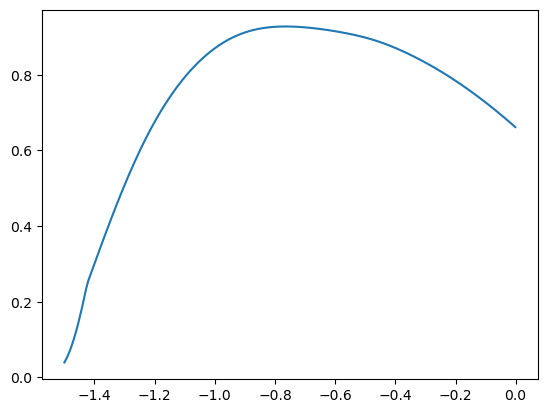

In [78]:
plt.plot(potential_vs_rhe, fe)